In [1]:
import json
import os
import sys

import numpy as np
import torch
import ubjson
from matplotlib import pyplot as plt

sys.path.insert(0, os.path.abspath('..'))
from xgbackprop.xgbackprop import XGBackpropLayer

torch.cuda.is_available()

/Users/randyardywibowo/miniconda3/envs/core/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


False

In [2]:
# load model from file
model_name = '/Users/randyardywibowo/Github/xgbackprop/models/model.json'
with open(model_name, "r") as fd:
    model = json.load(fd)

device = 'cuda'
model = XGBackpropLayer(model)

In [3]:
from numpy import loadtxt

# load data
dataset = loadtxt('../data/pima-indians-diabetes.csv', delimiter=",")

# split data into X and y
X = dataset[:, 0:8]
Y = dataset[:, 8]

In [4]:
x_tensor = torch.Tensor(X[:10, :])
# x_tensor = x_tensor[None, :]

model.train()
model(x_tensor)

tensor([0.9688, 0.2024, 0.2590, 0.0979, 0.9464, 0.2495, 0.3593, 0.6376, 0.8618,
        0.0476], grad_fn=<AddBackward0>)

In [5]:
model.eval()
model(x_tensor)

tensor([ 9.9948e-01,  3.5827e-03,  1.7496e-01, -1.1397e-02,  1.0003e+00,
        -2.6250e-04,  9.9498e-01,  4.6560e-04,  9.9978e-01,  1.0009e-02],
       grad_fn=<AddBackward0>)

In [8]:
import xgboost as xgb

model = xgb.Booster()
model.load_model(model_name)
# model.get_dump(dump_format='json')
x_matrix = xgb.DMatrix(X)
preds = model.predict(x_matrix)
pred_leaf = model.predict(x_matrix, pred_leaf=True)
preds


In [33]:
with open('/Users/randyardywibowo/Github/xgbackprop/models/model.json', "r") as fd:
    json_model = json.load(fd)

j_trees = json_model["learner"]["gradient_booster"]["model"]["trees"]

In [53]:
# list(pred_leaf.astype(int).flatten())

In [55]:
np.array([j_trees[i]["loss_changes"][leaf] for i, leaf in enumerate(list(pred_leaf.astype(int).flatten()))]).sum()

0.000229760666976

In [9]:
model.train()
# model = torch.jit.script(model)
# model = torch.compile(model)
input = torch.nn.Embedding(1, 8)
optimizer = torch.optim.Adam(list(model.parameters()) + list(input.parameters()))

In [10]:
outputs = []

In [11]:
for i in range(50):
    encoder_output = input(torch.tensor([0]))
    output = model(encoder_output)
    loss = torch.nn.BCELoss()(output, torch.tensor([1.]))
    outputs.append(output.detach().numpy())
    
    # if (i // 100) % 2 != 0:
    #     print("Target: -10")
        
    # else:
    #     print("Target: +10")
    #     loss = torch.square(output - 1)
    #     outputs.append(output.detach().numpy())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

RuntimeError: all elements of input should be between 0 and 1

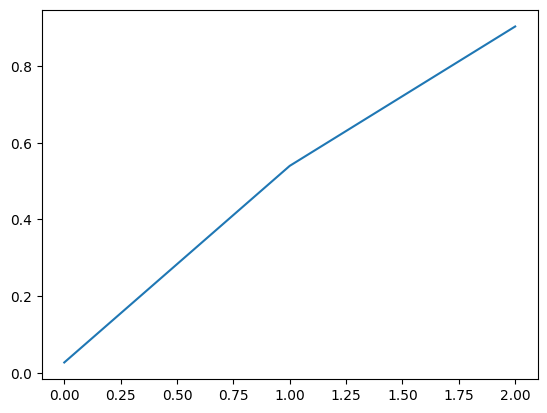

In [12]:
plt.plot(outputs)

In [13]:
len(outputs)

3